In [19]:
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import pearsonr, bootstrap, ttest_rel, ttest_ind

In [2]:
methods = ["IID", "COV", "ADV", "OOD"]
methodse = ["IID", "COV", "ADV", "OOD", "IID_FIX", "ADV_FIX", "OOD_FIX"]
level_names = {1: "Baseline", 2: "30%", 4: "15%", 8: "7.5%", 16: "3.75%"}
exps = ["Ratio", "Height"]

In [3]:
def powerset(s):
    x = len(s)
    subsets = [[s[j] for j in range(x) if (i & (1 << j))] for i in range(1 << x)]
    subsets = sorted(subsets, key=lambda x: len(x), reverse=True)
    return subsets[:-1]


def to_tukey_table(tukeyhsd_results):
    tukeyhsd = tukeyhsd_results.summary().data
    return pd.DataFrame(tukeyhsd[1:], columns=tukeyhsd[0])


def find_tukey_groups(df):
    groups = sorted(set(df["group1"]).union(df["group2"]))
    matrix = pd.DataFrame(0, index=groups, columns=groups)

    # Filling the matrix based on the Tukey table conditions
    for _, row in df.iterrows():
        g1, g2, diff, reject = (
            row["group1"],
            row["group2"],
            row["meandiff"],
            row["reject"],
        )
        if reject:  # Only consider the case where reject is True
            matrix.at[g2, g1] = 1 if diff > 0 else -1
            matrix.at[g1, g2] = -1 if diff > 0 else 1

    groups = sorted(set(df["group1"]).union(df["group2"]))
    tukey_groups = []
    ranks = []
    for group in groups:
        non_sig_groups = matrix.loc[group, matrix.loc[group] == 0].index
        subsets = powerset(non_sig_groups)
        for subset in subsets:
            if np.any([set(subset).issubset(g) for g in tukey_groups]):
                continue

            vals = np.array([matrix.loc[g, subset].values for g in subset]).flatten()
            rank_vals = np.array([matrix.loc[g, :].values for g in subset]).flatten()
            if np.all(vals == 0):
                tukey_groups.append(set(subset))
                rank = np.sum(rank_vals)
                ranks.append(rank)

    sorted_groups = sorted(tukey_groups, key=lambda g: ranks[tukey_groups.index(g)])
    return sorted_groups


def results_formatter(anova_results, tukeyhsd_results, name_map=None):
    for i in anova_results.index[:-1]:
        anova_results.at[i, "Eta"] = (
            anova_results.loc[i].sum_sq / anova_results.sum_sq.sum()
        )
    F = round(anova_results.loc[anova_results.index[0], "F"], 1)
    df = int(anova_results.loc[anova_results.index[0], "df"])
    residual_d = int(anova_results.loc["Residual", "df"])
    F_str = (
        f"$F_{{({df}, {residual_d})}} = {F:.1f}$"
        if F >= 0.1
        else f"$F_{{({df}, {residual_d})}} < 0.$"
    )
    p = round(anova_results.loc[anova_results.index[0], "PR(>F)"], 3)
    if p > 0.05:
        p_str = f"$p = {p:.3f}$"
    elif p > 0.01:
        p_str = f"$p = \\mathbf{{{p:.3f}}}$"
    elif p > 0.001:
        p_str = f"$p = \\mathbf{{{p:.3f}}}$"
    else:
        p_str = f"$p < \\mathbf{{{0.001}}}$"
    etasq = round(anova_results.loc[anova_results.index[0], "Eta"], 3)
    if etasq >= 0.14:
        etasq_str = f"$\\eta^2 = \\mathbf{{{etasq:.2f}}}$"
    elif etasq >= 0.06:
        etasq_str = f"$\\eta^2 = \\mathit{{{etasq:.2f}}}$"
    elif etasq >= 0.01:
        etasq_str = f"$\\eta^2 = {etasq:.2f}$"
    else:
        etasq_str = f"$\\eta^2 < 0.01$"
    tukey_groups = find_tukey_groups(tukeyhsd_results)
    if name_map is not None:
        tukey_groups = [[name_map[g] for g in group] for group in tukey_groups]
    tukey_str = ">".join([f'({", ".join([str(v) for v in g])})' for g in tukey_groups])
    tukey_str = "$\\mathrm{" + tukey_str + "}$"

    return F_str, p_str, etasq_str, tukey_str

In [4]:
cnn_H = pd.read_feather("results/formated_data/cnn_height.feather")
# combined = pd.concat([cnn] + humans, axis=0).reset_index(drop=True)
cnn_H["RawRatio"] = cnn_H.h / cnn_H.H
cnn_H["absError"] = np.abs(cnn_H.RawRatio - cnn_H.Pred)
cnn_H["Error"] = -(cnn_H.RawRatio - cnn_H.Pred)
cnn_H_agg = (
    cnn_H.groupby(["Model", "Run", "Type", "Method", "Level", "h", "H"])[
        ["Pred", "RawRatio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
    .groupby(["Model", "Run", "Type", "Method", "Level", "H"])[
        ["Pred", "RawRatio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
)
cnn_H_agg["SmallHeight"] = np.where(cnn_H_agg.H < 20, "short", "tall")
cnn_H_cat = cnn_H_agg

cnn_R = pd.read_feather("results/formated_data/cnn_ratio.feather")
cnn_R["RawRatio"] = cnn_R.h / cnn_R.H
cnn_R["absError"] = np.abs(cnn_R.RawRatio - cnn_R.Pred)
cnn_R["Error"] = -(cnn_R.RawRatio - cnn_R.Pred)
cnn_R["Ratio"] = cnn_R.RawRatio.apply(lambda x: round(x, 2))
cnn_R["SmallHeight"] = np.where(cnn_R.H < 20, "short", "tall")
cnn_R_agg = (
    cnn_R.groupby(["Model", "Run", "Type", "Method", "Level", "h", "H"])[
        ["Pred", "RawRatio", "Ratio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
)
cnn_R_agg["Ratio"] = round(cnn_R_agg.RawRatio, 2)
cnn_R_agg = (
    cnn_R_agg.groupby(["Model", "Run", "Type", "Method", "Level", "Ratio"])[
        ["Pred", "RawRatio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
)
cnn_R_cat = (
    cnn_R.groupby(["Model", "Run", "Type", "Method", "Level", "h", "H", "SmallHeight"])[
        ["Pred", "RawRatio", "Ratio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
    .groupby(["Model", "Run", "Type", "Method", "Level", "Ratio", "SmallHeight"])[
        ["Pred", "RawRatio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
)


cnn_H_agg["Exp"] = "Height"
cnn_R_agg["Exp"] = "Ratio"
cnn_H_cat["Exp"] = "Height"
cnn_R_cat["Exp"] = "Ratio"
cnn = pd.concat([cnn_H_agg, cnn_R_agg], axis=0).reset_index(drop=True)
# cnn.loc[cnn.H < 20, "SmallHeight"] = "short"
# cnn.loc[cnn.H >= 20, "SmallHeight"] = "tall"
cnn_cat = pd.concat([cnn_H_cat, cnn_R_cat], axis=0).reset_index(drop=True)
cnn_feature = cnn.copy()
cnn_feature = cnn_feature[cnn_feature.Method != "COV"].reset_index(drop=True)
cnn_feature["Feature"] = cnn_feature.Method.apply(
    lambda x: "with" if "_FIX" in x else "without"
)
cnn_feature["Method"] = cnn_feature.Method.apply(lambda x: x.split("_")[0])

In [6]:
cnn[(cnn.Level == 2) & (cnn.Method.isin(methods)) & (cnn.Exp == "Height")]

,Model,Run,Type,Method,Level,H,Pred,RawRatio,absError,Error,SmallHeight,Exp,Ratio
0,ResNet,0,1,ADV,2,7.0,0.566336,0.785714,0.219379,-0.219379,short,Height,NaN
1,ResNet,0,1,ADV,2,14.0,0.624018,0.642857,0.044123,-0.018839,short,Height,NaN
2,ResNet,0,1,ADV,2,17.0,0.560765,0.617647,0.068282,-0.056882,short,Height,NaN
3,ResNet,0,1,ADV,2,20.0,0.568076,0.600000,0.043049,-0.031924,tall,Height,NaN
4,ResNet,0,1,ADV,2,30.0,0.565619,0.566667,0.020191,-0.001047,tall,Height,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20699,VGG,4,5,OOD,2,70.0,0.492984,0.178571,0.314413,0.314413,tall,Height,NaN
20700,VGG,4,5,OOD,2,75.0,0.529113,0.133333,0.395779,0.395779,tall,Height,NaN
20701,VGG,4,5,OOD,2,77.0,0.549358,0.116883,0.432475,0.432475,tall,Height,NaN
20702,VGG,4,5,OOD,2,78.0,0.556716,0.108974,0.447742,0.447742,tall,Height,NaN


In [8]:
data = cnn[(cnn.Level == 2) & (cnn.Method.isin(methods))]
anova_lm(ols("absError ~ (C(Type) + Method) * Model", data).fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(Type),4.0,0.140587,0.035147,7.668347,3.670886e-06
Method,3.0,4.396935,1.465645,319.776271,4.465402e-195
Model,1.0,0.374951,0.374951,81.807256,1.894097e-19
C(Type):Model,4.0,0.003898,0.000974,0.212618,9.315473e-01
Method:Model,3.0,0.085715,0.028572,6.233833,3.185457e-04
Residual,7298.0,33.449254,0.004583,NaN,NaN


In [6]:
for method in methods:
    data = cnn[(cnn.Exp == "Height") & (cnn.Level == 2) & (cnn.Method == method)]

    anova_results = anova_lm(ols("absError ~ C(Type) + Model", data).fit())
    tukeyhsd_results = to_tukey_table(pairwise_tukeyhsd(data["absError"], data["Type"]))
    F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
    print(f"{method}:\t{F}\t{p}\t{etasq}\t{tukey_str}\t")

IID:	$F_{(4, 794)}=0.5$	$0.710$	$< 0.01$	(1, 2, 3, 4, 5)	
COV:	$F_{(4, 794)}=2.4$	$0.052$	$0.01$	(1, 2, 3, 4, 5)	
ADV:	$F_{(4, 794)}=0.7$	$0.616$	$< 0.01$	(1, 2, 3, 4, 5)	
OOD:	$F_{(4, 794)}=14.2$	$< 0.001$	$0.07$	(1, 2, 3, 4)>(5)	


In [18]:
for exp in exps:
    print(f"Study I Exp {exps.index(exp)+1}: {exp} sampling")
    data = cnn[(cnn.Exp == exp) & (cnn.Level == 2) & (cnn.Method.isin(methods))]
    row_str = ""

    row_str += "Type\t"
    anova_results = anova_lm(ols("absError ~ C(Type) + Method + Model", data).fit())
    tukeyhsd_results = to_tukey_table(pairwise_tukeyhsd(data["absError"], data["Type"]))
    F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
    row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"

    row_str += "\nSampling\t"
    anova_results = anova_lm(ols("absError ~ Method + C(Type) + Model", data).fit())
    tukeyhsd_results = to_tukey_table(
        pairwise_tukeyhsd(data["absError"], data["Method"])
    )
    F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
    row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"

    row_str += "\nModel\t"
    anova_results = anova_lm(ols("absError ~ Model + Method + C(Type)", data).fit())
    tukeyhsd_results = to_tukey_table(
        pairwise_tukeyhsd(data["absError"], data["Model"])
    )
    F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
    row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"

    print(row_str)

Study I Exp 1: Ratio sampling
Type	$F_{(4, 4105)} = 1.4$	$p = 0.216$	$\eta^2 < 0.01$	$\mathrm{(1, 2, 3, 4, 5)}$	
Sampling	$F_{(3, 4105)} = 348.9$	$p < \mathbf{0.001}$	$\eta^2 = \mathbf{0.20}$	$\mathrm{(COV, ADV, IID)>(OOD)}$	
Model	$F_{(1, 4105)} = 48.6$	$p < \mathbf{0.001}$	$\eta^2 < 0.01$	$\mathrm{(VGG)>(ResNet)}$	
Study I Exp 2: Height sampling
Type	$F_{(4, 3191)} = 8.0$	$p < \mathbf{0.001}$	$\eta^2 < 0.01$	$\mathrm{(1, 2, 3, 4)>(5)}$	
Sampling	$F_{(3, 3191)} = 72.9$	$p < \mathbf{0.001}$	$\eta^2 = \mathit{0.06}$	$\mathrm{(COV)>(IID)>(ADV)>(OOD)}$	
Model	$F_{(1, 3191)} = 36.6$	$p < \mathbf{0.001}$	$\eta^2 = 0.01$	$\mathrm{(VGG)>(ResNet)}$	


In [12]:
data = cnn_cat[
    (cnn_cat.Exp == "Height") & (cnn_cat.Level == 2) & (cnn_cat.Method.isin(methods))
]
anova_results = anova_lm(
    ols("absError ~ SmallHeight + C(Type) + Method + Model", data).fit()
)
tukeyhsd_results = to_tukey_table(
    pairwise_tukeyhsd(data["absError"], data["SmallHeight"])
)
F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
print(f"{F}\t{p}\t{etasq}\t{tukey_str}\t")
# anova_results

$F_{(1, 3190)}=329.0$	$< 0.001$	$0.09$	(tall)>(short)	


In [217]:
# Study 1

for exp in exps:
    print(f"Study I Exp {exps.index(exp)+1}: {exp} sampling")

    for level in [2]:
        # ------- Type effect --------------
        row_str = "Type (all sampling)\t"
        for model in ["VGG", "ResNet"]:
            data = cnn[
                (cnn.Exp == exp)
                & (cnn.Level == level)
                & (cnn.Model == model)
                & (cnn.Method.isin(methods))
            ]
            # raise
            anova_results = anova_lm(ols("absError ~ C(Type) + Method", data).fit())
            tukeyhsd_results = to_tukey_table(
                pairwise_tukeyhsd(data["absError"], data["Type"])
            )

            F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
            row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
        print(row_str)

        # ------- Method effect --------------
        row_str = "Sampling (all types)\t"
        for model in ["VGG", "ResNet"]:
            data = cnn[
                (cnn.Exp == exp)
                & (cnn.Level == level)
                & (cnn.Model == model)
                & (cnn.Method.isin(methods))
            ]
            # raise
            anova_results = anova_lm(ols("absError ~ Method + C(Type)", data).fit())
            tukeyhsd_results = to_tukey_table(
                pairwise_tukeyhsd(data["absError"], data["Method"])
            )

            F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
            row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
        print(row_str)

        for bartype in range(1, 6):
            row_str = f"Sampling (Type {bartype})\t "
            for model in ["VGG", "ResNet"]:
                data = cnn[
                    (cnn.Exp == exp)
                    & (cnn.Level == level)
                    & (cnn.Model == model)
                    & (cnn.Method.isin(methods))
                    & (cnn.Type == bartype)
                ]
                anova_results = anova_lm(ols("absError ~ Method", data).fit())
                tukeyhsd_results = to_tukey_table(
                    pairwise_tukeyhsd(data["absError"], data["Method"])
                )

                F, p, etasq, tukey_str = results_formatter(
                    anova_results, tukeyhsd_results
                )
                row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
            print(row_str)

        # ------- Categorical effect --------------
        # row_str = "Categorical (all types)\t"
        # for model in ["VGG", "ResNet"]:
        #     data = cnn_cat[
        #         (cnn_cat.Exp == exp)
        #         & (cnn_cat.Level == level)
        #         & (cnn_cat.Model == model)
        #         & (cnn_cat.Method.isin(methods))
        #     ]
        #     # raise
        #     anova_results = anova_lm(ols("absError ~ SmallHeight", data).fit())
        #     tukeyhsd_results = to_tukey_table(
        #         pairwise_tukeyhsd(data["absError"], data["SmallHeight"])
        #     )

        #     F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
        #     row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
        # print(row_str)

        for bartype in range(1, 6):
            row_str = f"Categorical (Type {bartype})\t "
            for model in ["VGG", "ResNet"]:
                data = cnn_cat[
                    (cnn_cat.Exp == exp)
                    & (cnn_cat.Level == level)
                    & (cnn_cat.Model == model)
                    & (cnn_cat.Method.isin(methods))
                    & (cnn_cat.Type == bartype)
                ]
                anova_results = anova_lm(ols("absError ~ SmallHeight", data).fit())
                tukeyhsd_results = to_tukey_table(
                    pairwise_tukeyhsd(data["absError"], data["SmallHeight"])
                )

                F, p, etasq, tukey_str = results_formatter(
                    anova_results, tukeyhsd_results
                )
                row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
            print(row_str)

Study I Exp 1: Ratio sampling
Type (all sampling)	$F_{(4, 3779)}=1.9$	$0.106$	$< 0.01$	(1, 2, 3, 4, 5)	$F_{(4, 3779)}=0.7$	$0.583$	$< 0.01$	(1, 2, 3, 4, 5)	
Sampling (all types)	$F_{(3, 3779)}=424.4$	$< 0.001$	$0.25$	(IID, ADV, COV)>(OOD)	$F_{(3, 3779)}=433.6$	$< 0.001$	$0.26$	(IID, ADV, COV)>(OOD)	
Sampling (Type 1)	 $F_{(3, 761)}=86.3$	$< 0.001$	$0.25$	(IID, ADV, COV)>(OOD)	$F_{(3, 761)}=97.4$	$< 0.001$	$0.28$	(IID, ADV, COV)>(OOD)	
Sampling (Type 2)	 $F_{(3, 761)}=90.3$	$< 0.001$	$0.26$	(IID, ADV, COV)>(OOD)	$F_{(3, 761)}=90.1$	$< 0.001$	$0.26$	(IID, ADV, COV)>(OOD)	
Sampling (Type 3)	 $F_{(3, 761)}=87.8$	$< 0.001$	$0.26$	(IID, ADV, COV)>(OOD)	$F_{(3, 761)}=90.4$	$< 0.001$	$0.26$	(IID, ADV, COV)>(OOD)	
Sampling (Type 4)	 $F_{(3, 761)}=91.2$	$< 0.001$	$0.26$	(IID, ADV, COV)>(OOD)	$F_{(3, 761)}=83.7$	$< 0.001$	$0.25$	(IID, ADV, COV)>(OOD)	
Sampling (Type 5)	 $F_{(3, 723)}=75.2$	$< 0.001$	$0.24$	(IID, ADV, COV)>(OOD)	$F_{(3, 723)}=73.0$	$< 0.001$	$0.23$	(IID, ADV, COV)>(OOD)	
Categoric

In [218]:
# Study 2
level_names = {1: "60%", 2: "30%", 4: "15%", 8: "7.5%", 16: "3.75%"}

for exp in exps:
    print(f"Study II Exp {exps.index(exp)+1}: {exp} downsampling")

    # ------- Level effect --------------
    row_str = "Level (all sampling & types)\t"
    for model in ["VGG", "ResNet"]:
        data = cnn[
            (cnn.Exp == exp)
            & (cnn.Level != 1)
            & (cnn.Model == model)
            & (cnn.Method.isin(methods))
        ]
        # raise
        anova_results = anova_lm(
            ols("absError ~ C(Level) + C(Type) + Method", data).fit()
        )
        tukeyhsd_results = to_tukey_table(
            pairwise_tukeyhsd(data["absError"], data["Level"])
        )

        F, p, etasq, tukey_str = results_formatter(
            anova_results, tukeyhsd_results, level_names
        )
        row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
    print(row_str)

    for level in [4, 8, 16]:
        # ------- Type effect --------------
        row_str = f"Type ({level_names[level]} all sampling)\t"
        for model in ["VGG", "ResNet"]:
            data = cnn[
                (cnn.Exp == exp)
                & (cnn.Level == level)
                & (cnn.Model == model)
                & (cnn.Method.isin(methods))
            ]
            # raise
            anova_results = anova_lm(ols("absError ~ C(Type) + Method", data).fit())
            tukeyhsd_results = to_tukey_table(
                pairwise_tukeyhsd(data["absError"], data["Type"])
            )

            F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
            row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
        print(row_str)

        # ------- Method effect --------------
        row_str = f"Sampling ({level_names[level]} all types)\t"
        for model in ["VGG", "ResNet"]:
            data = cnn[
                (cnn.Exp == exp)
                & (cnn.Level == level)
                & (cnn.Model == model)
                & (cnn.Method.isin(methods))
            ]
            # raise
            anova_results = anova_lm(ols("absError ~ Method + C(Type)", data).fit())
            tukeyhsd_results = to_tukey_table(
                pairwise_tukeyhsd(data["absError"], data["Method"])
            )

            F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
            row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
        print(row_str)

        for bartype in range(1, 6):
            row_str = f"Sampling ({level_names[level]} Type {bartype})\t "
            for model in ["VGG", "ResNet"]:
                data = cnn[
                    (cnn.Exp == exp)
                    & (cnn.Level == level)
                    & (cnn.Model == model)
                    & (cnn.Method.isin(methods))
                    & (cnn.Type == bartype)
                ]
                anova_results = anova_lm(ols("absError ~ Method", data).fit())
                tukeyhsd_results = to_tukey_table(
                    pairwise_tukeyhsd(data["absError"], data["Method"])
                )

                F, p, etasq, tukey_str = results_formatter(
                    anova_results, tukeyhsd_results
                )
                row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
            print(row_str)

Study II Exp 1: Ratio downsampling
Level (all sampling & types)	$F_{(3, 15256)}=1266.9$	$< 0.001$	$0.15$	(30%)>(15%)>(7.5%)>(3.75%)	$F_{(3, 15256)}=1405.0$	$< 0.001$	$0.16$	(30%)>(15%)>(7.5%)>(3.75%)	
Type (15% all sampling)	$F_{(4, 3841)}=0.7$	$0.617$	$< 0.01$	(1, 2, 3, 4, 5)	$F_{(4, 3841)}=1.4$	$0.216$	$< 0.01$	(1, 2, 3, 4, 5)	
Sampling (15% all types)	$F_{(3, 3841)}=838.1$	$< 0.001$	$0.40$	(IID, COV)>(ADV)>(OOD)	$F_{(3, 3841)}=751.6$	$< 0.001$	$0.37$	(IID, COV)>(ADV)>(OOD)	
Sampling (15% Type 1)	 $F_{(3, 779)}=160.0$	$< 0.001$	$0.38$	(IID, COV)>(ADV)>(OOD)	$F_{(3, 779)}=143.3$	$< 0.001$	$0.36$	(IID, COV)>(ADV)>(OOD)	
Sampling (15% Type 2)	 $F_{(3, 779)}=191.0$	$< 0.001$	$0.42$	(IID, ADV, COV)>(OOD)	$F_{(3, 779)}=157.3$	$< 0.001$	$0.38$	(IID, COV)>(ADV)>(OOD)	
Sampling (15% Type 3)	 $F_{(3, 779)}=197.7$	$< 0.001$	$0.43$	(IID, ADV, COV)>(OOD)	$F_{(3, 779)}=163.9$	$< 0.001$	$0.39$	(IID, COV)>(ADV)>(OOD)	
Sampling (15% Type 4)	 $F_{(3, 779)}=178.7$	$< 0.001$	$0.41$	(IID, COV)>(IID, ADV)

In [14]:
# Study 2 main text
level_names = {1: "60%", 2: "30%", 4: "15%", 8: "7.5%", 16: "3.75%"}

for exp in exps:
    print(f"Study II Exp {exps.index(exp)+1}: {exp} downsampling")

    # ------- Level effect --------------
    row_str = "Level (all sampling)\t"
    for model in ["VGG"]:
        data = cnn[
            (cnn.Exp == exp)
            & (cnn.Level != 1)
            & (cnn.Type == 1)
            & (cnn.Model == model)
            & (cnn.Method.isin(methods))
        ]
        # raise
        anova_results = anova_lm(
            ols("absError ~ C(Level) + C(Type) + Method", data).fit()
        )
        tukeyhsd_results = to_tukey_table(
            pairwise_tukeyhsd(data["absError"], data["Level"])
        )

        F, p, etasq, tukey_str = results_formatter(
            anova_results, tukeyhsd_results, level_names
        )
        row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
    print(row_str.replace("%", "\\%"))

    for level in [4, 8, 16]:
        # ------- Method effect --------------
        row_str = f"Sampling (level {level_names[level]})\t"
        for model in ["VGG"]:
            data = cnn[
                (cnn.Exp == exp)
                & (cnn.Level == level)
                & (cnn.Type == 1)
                & (cnn.Model == model)
                & (cnn.Method.isin(methods))
            ]
            # raise
            anova_results = anova_lm(ols("absError ~ Method + C(Type)", data).fit())
            tukeyhsd_results = to_tukey_table(
                pairwise_tukeyhsd(data["absError"], data["Method"])
            )

            F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
            row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
        print(row_str.replace("%", "\\%"))

        # for bartype in range(1, 2):
        #     row_str = f"Sampling ({level_names[level]} Type {bartype})\t "
        #     for model in ["VGG", "ResNet"]:
        #         data = cnn[
        #             (cnn.Exp == exp)
        #             & (cnn.Level == level)
        #             & (cnn.Model == model)
        #             & (cnn.Method.isin(methods))
        #             & (cnn.Type == bartype)
        #         ]
        #         anova_results = anova_lm(ols("absError ~ Method", data).fit())
        #         tukeyhsd_results = to_tukey_table(
        #             pairwise_tukeyhsd(data["absError"], data["Method"])
        #         )

        #         F, p, etasq, tukey_str = results_formatter(
        #             anova_results, tukeyhsd_results
        #         )
        #         row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
        #     print(row_str)

Study II Exp 1: Ratio downsampling
Level (all sampling)	$F_{(3, 1641)} = 150.2$	$p < \mathbf{0.001}$	$\eta^2 = \mathbf{0.17}$	$\mathrm{(30\%)>(15\%)>(7.5\%)>(3.75\%)}$	
Sampling (level 15\%)	$F_{(3, 408)} = 68.2$	$p < \mathbf{0.001}$	$\eta^2 = \mathbf{0.33}$	$\mathrm{(COV, ADV, IID)>(OOD)}$	
Sampling (level 7.5\%)	$F_{(3, 408)} = 112.1$	$p < \mathbf{0.001}$	$\eta^2 = \mathbf{0.45}$	$\mathrm{(COV, IID)>(ADV)>(OOD)}$	
Sampling (level 3.75\%)	$F_{(3, 408)} = 56.6$	$p < \mathbf{0.001}$	$\eta^2 = \mathbf{0.29}$	$\mathrm{(COV)>(IID)>(ADV)>(OOD)}$	
Study II Exp 2: Height downsampling
Level (all sampling)	$F_{(3, 1273)} = 70.6$	$p < \mathbf{0.001}$	$\eta^2 = \mathit{0.12}$	$\mathrm{(30\%)>(15\%)>(7.5\%)>(3.75\%)}$	
Sampling (level 15\%)	$F_{(3, 316)} = 21.6$	$p < \mathbf{0.001}$	$\eta^2 = \mathbf{0.17}$	$\mathrm{(COV, IID)>(ADV, IID)>(OOD)}$	
Sampling (level 7.5\%)	$F_{(3, 316)} = 34.1$	$p < \mathbf{0.001}$	$\eta^2 = \mathbf{0.24}$	$\mathrm{(COV, IID)>(OOD, ADV)}$	
Sampling (level 3.75\%)	$F_{

In [211]:
# Study 3
level_names = {1: "60%", 2: "30%", 4: "15%", 8: "7.5%", 16: "3.75%"}

for exp in exps:
    print(f"Study III Exp {exps.index(exp)+1}: {exp}")

    for level in [2, 4, 8]:
        for bartype in range(1, 2):
            # ------- data feature effect --------------
            row_str = f"Feature ({level_names[level]} Type {bartype} all sampling)\t "
            for model in ["VGG", "ResNet"]:
                data = cnn_feature[
                    (cnn_feature.Exp == exp)
                    & (cnn_feature.Level == level)
                    & (cnn_feature.Model == model)
                    & (cnn_feature.Type == bartype)
                ]
                anova_results = anova_lm(ols("absError ~ Feature", data).fit())
                tukeyhsd_results = to_tukey_table(
                    pairwise_tukeyhsd(data["absError"], data["Feature"])
                )

                F, p, etasq, tukey_str = results_formatter(
                    anova_results, tukeyhsd_results
                )
                row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
            print(row_str)

            for method in ["IID", "ADV", "OOD"]:
                row_str = f"Feature ({level_names[level]} Type {bartype} {method})\t "
                for model in ["VGG", "ResNet"]:
                    data = cnn_feature[
                        (cnn_feature.Exp == exp)
                        & (cnn_feature.Level == level)
                        & (cnn_feature.Model == model)
                        & (cnn_feature.Type == bartype)
                        & (cnn_feature.Method == method)
                    ]
                    anova_results = anova_lm(ols("absError ~ Feature", data).fit())
                    tukeyhsd_results = to_tukey_table(
                        pairwise_tukeyhsd(data["absError"], data["Feature"])
                    )

                    F, p, etasq, tukey_str = results_formatter(
                        anova_results, tukeyhsd_results
                    )
                    row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
                print(row_str)

Study III Exp 1: Ratio
Feature (30% Type 1 all methods)	 $F_{(1, 1145)}=23.0$	$< 0.001$	$0.02$	(with)>(without)	$F_{(1, 1145)}=10.1$	$0.002$	$< 0.01$	(with)>(without)	
Feature (30% Type 1 IID)	 $F_{(1, 379)}=36.2$	$< 0.001$	$0.09$	(with)>(without)	$F_{(1, 379)}=6.0$	$0.015$	$0.02$	(without)>(with)	
Feature (30% Type 1 ADV)	 $F_{(1, 376)}<0.1$	$0.843$	$< 0.01$	(with, without)	$F_{(1, 376)}=7.9$	$0.005$	$0.02$	(without)>(with)	
Feature (30% Type 1 OOD)	 $F_{(1, 386)}=27.9$	$< 0.001$	$0.07$	(with)>(without)	$F_{(1, 386)}=17.3$	$< 0.001$	$0.04$	(with)>(without)	
Feature (15% Type 1 all methods)	 $F_{(1, 1182)}=72.2$	$< 0.001$	$0.06$	(with)>(without)	$F_{(1, 1182)}=43.6$	$< 0.001$	$0.04$	(with)>(without)	
Feature (15% Type 1 IID)	 $F_{(1, 386)}=7.5$	$0.006$	$0.02$	(with)>(without)	$F_{(1, 386)}=5.7$	$0.018$	$0.01$	(with)>(without)	
Feature (15% Type 1 ADV)	 $F_{(1, 398)}=16.3$	$< 0.001$	$0.04$	(with)>(without)	$F_{(1, 398)}=10.1$	$0.002$	$0.02$	(with)>(without)	
Feature (15% Type 1 OOD)	 $F

In [5]:
# Study 3 main text
level_names = {1: "60%", 2: "30%", 4: "15%", 8: "7.5%", 16: "3.75%"}

for exp in exps:
    print(f"Study III Exp {exps.index(exp)+1}: {exp}")

    for level in [2, 4, 8]:
        for bartype in range(1, 2):
            # ------- data feature effect --------------
            row_str = f"Feature (level {level_names[level]})\t "
            for model in ["VGG"]:
                data = cnn_feature[
                    (cnn_feature.Exp == exp)
                    & (cnn_feature.Level == level)
                    & (cnn_feature.Model == model)
                    & (cnn_feature.Type == bartype)
                ]
                anova_results = anova_lm(ols("absError ~ Feature", data).fit())
                tukeyhsd_results = to_tukey_table(
                    pairwise_tukeyhsd(data["absError"], data["Feature"])
                )

                F, p, etasq, tukey_str = results_formatter(
                    anova_results, tukeyhsd_results
                )
                row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
            print(row_str.replace("%", "\\%"))

            # for method in ["IID", "ADV", "OOD"]:
            #     row_str = f"Feature ({level_names[level]} Type {bartype} {method})\t "
            #     for model in ["VGG"]:
            #         data = cnn_feature[
            #             (cnn_feature.Exp == exp)
            #             & (cnn_feature.Level == level)
            #             & (cnn_feature.Model == model)
            #             & (cnn_feature.Type == bartype)
            #             & (cnn_feature.Method == method)
            #         ]
            #         anova_results = anova_lm(ols("absError ~ Feature", data).fit())
            #         tukeyhsd_results = to_tukey_table(
            #             pairwise_tukeyhsd(data["absError"], data["Feature"])
            #         )

            #         F, p, etasq, tukey_str = results_formatter(
            #             anova_results, tukeyhsd_results
            #         )
            #         row_str += f"{F}\t{p}\t{etasq}\t{tukey_str}\t"
            #     print(row_str.replace("%", "\\%"))

Study III Exp 1: Ratio
Feature (level 30\%)	 $F_{(1, 616)} = 9.3$	$p = \mathbf{0.002}$	$\eta^2 = 0.01$	$\mathrm{(with)>(without)}$	
Feature (level 15\%)	 $F_{(1, 616)} = 34.8$	$p < \mathbf{0.001}$	$\eta^2 = 0.05$	$\mathrm{(with)>(without)}$	
Feature (level 7.5\%)	 $F_{(1, 616)} = 43.5$	$p < \mathbf{0.001}$	$\eta^2 = \mathit{0.07}$	$\mathrm{(with)>(without)}$	
Study III Exp 2: Height
Feature (level 30\%)	 $F_{(1, 478)} = 20.9$	$p < \mathbf{0.001}$	$\eta^2 = 0.04$	$\mathrm{(with)>(without)}$	
Feature (level 15\%)	 $F_{(1, 478)} = 35.5$	$p < \mathbf{0.001}$	$\eta^2 = \mathit{0.07}$	$\mathrm{(with)>(without)}$	
Feature (level 7.5\%)	 $F_{(1, 478)} = 62.8$	$p < \mathbf{0.001}$	$\eta^2 = \mathit{0.12}$	$\mathrm{(with)>(without)}$	


In [215]:
cell = pd.read_feather(
    "/users/PAS1575/jiang2126/Project/perception/results/formated_data/cell.feather"
)
cell["Number"] = cell["Number"].astype("int")
node = pd.read_feather(
    "/users/PAS1575/jiang2126/Project/perception/results/formated_data/node.feather"
)
node["Number"] = node["Number"].astype("int")
cell["absError"] = np.abs(cell["Number"] - cell["Pred"])
node["absError"] = np.abs(node["Number"] - node["Pred"])
cell = (
    cell.groupby(["Model", "Run", "Method", "Level", "Number"])
    .mean()
    .dropna()
    .reset_index()
)
node = (
    node.groupby(["Model", "Run", "Method", "Level", "Number"])
    .mean()
    .dropna()
    .reset_index()
)
cell["Exp"] = "Cell"
node["Exp"] = "Node"
cellnode = pd.concat([cell, node], axis=0).reset_index(drop=True)

In [214]:
node.Method.unique()

['ADV', 'ADV_FIX', 'COV', 'IID', 'OOD', 'OOD_FIX']
Categories (6, object): ['ADV', 'ADV_FIX', 'COV', 'IID', 'OOD', 'OOD_FIX']

In [21]:
# 定义计算Cohen's d的函数
def cohens_d(group1, group2):
    # 计算两个样本的均值
    mean1, mean2 = np.mean(group1), np.mean(group2)

    # 计算两个样本的标准差
    std1, std2 = np.std(group1, ddof=1), np.std(group2, ddof=1)

    # 计算两个样本大小
    n1, n2 = len(group1), len(group2)

    # 计算合并标准差
    pooled_std = np.sqrt(
        ((std1**2) * (n1 - 1) + (std2**2) * (n2 - 1)) / (n1 + n2 - 2)
    )

    # 计算Cohen's d
    d = (mean1 - mean2) / pooled_std

    return d

In [11]:
cnn

,Model,Run,Type,Method,Level,H,Pred,RawRatio,absError,Error,SmallHeight,Exp,Ratio
0,ResNet,0,1,ADV,2,7.0,0.566336,0.785714,0.219379,-0.219379,short,Height,NaN
1,ResNet,0,1,ADV,2,14.0,0.624018,0.642857,0.044123,-0.018839,short,Height,NaN
2,ResNet,0,1,ADV,2,17.0,0.560765,0.617647,0.068282,-0.056882,short,Height,NaN
3,ResNet,0,1,ADV,2,20.0,0.568076,0.600000,0.043049,-0.031924,tall,Height,NaN
4,ResNet,0,1,ADV,2,30.0,0.565619,0.566667,0.020191,-0.001047,tall,Height,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47531,VGG,4,5,OOD_FIX,8,NaN,0.182760,0.800046,0.617286,-0.617286,NaN,Ratio,0.80
47532,VGG,4,5,OOD_FIX,8,NaN,0.194737,0.810361,0.615625,-0.615625,NaN,Ratio,0.81
47533,VGG,4,5,OOD_FIX,8,NaN,0.209731,0.919911,0.710180,-0.710180,NaN,Ratio,0.92
47534,VGG,4,5,OOD_FIX,8,NaN,0.177295,0.930103,0.752807,-0.752807,NaN,Ratio,0.93


In [22]:
# Study 3 Student's T-test
level_names = {1: "60%", 2: "30%", 4: "15%", 8: "7.5%", 16: "3.75%"}

for exp in exps:
    print(f"Study III Exp {exps.index(exp)+1}: {exp}")

    for level in [2, 4, 8]:
        for bartype in range(1, 2):
            # ------- data feature effect --------------
            row_str = f"Feature (level {level_names[level]})\t "
            for model in ["VGG"]:
                for method in ['ALL']:
                    if method == 'ALL':
                        data = cnn_feature[
                            (cnn_feature.Exp == exp)
                            & (cnn_feature.Level == level)
                            & (cnn_feature.Model == model)
                            & (cnn_feature.Type == bartype)
                        ]
                    else:
                        data = cnn_feature[
                            (cnn_feature.Exp == exp)
                            & (cnn_feature.Level == level)
                            & (cnn_feature.Model == model)
                            & (cnn_feature.Type == bartype)
                            & (cnn_feature.Method==method)
                        ]
                    group1 = np.array(data[data.Feature == "without"].absError)
                    group2 = np.array(data[data.Feature == "with"].absError)
                    # 进行配对样本T检验
                    t, p = ttest_rel(group1, group2)
                    p = round(p, 3)
                    if p > 0.05:
                        p_str = f"$p = {p:.3f}$"
                    elif p > 0.01:
                        p_str = f"$p = \\mathbf{{{p:.3f}}}$"
                    elif p > 0.001:
                        p_str = f"$p = \\mathbf{{{p:.3f}}}$"
                    else:
                        p_str = f"$p < \\mathbf{{{0.001}}}$"

                    # 计算Cohen's d
                    mean_diff = np.mean(group1 - group2)
                    std_diff = np.std(group1 - group2, ddof=1)
                    d = mean_diff / std_diff
                    d = round(d, 3)
                    if np.abs(d) > 0.8:
                        d_str = f"$d = \\mathbf{{{d:.3f}}}$"
                    elif np.abs(d) > 0.5:
                        d_str = f"$d = \\mathit{{{d:.3f}}}$"
                    elif np.abs(d) > 0.001:
                        d_str = f"$d = {d:.3f}$"
                    else:
                        d_str = f"$d < 0.001$"

                    # 计算自由度
                    df = len(group1) - 1
                    print(f"Feature (level {level_names[level]} )".replace('%', r'\%'), end="\t")
                    print(f"$T_{{({df})}}={t:.2f}$", end="\t")
                    print(p_str, end="\t")
                    print(d_str, end="\t")
                    print("$\mathrm{with > without}$")

Study III Exp 1: Ratio
Feature (level 30\% )	$T_{(616)}=5.20$	$p < \mathbf{0.001}$	$d = 0.296$	$\mathrm{with > without}$
Feature (level 15\% )	$T_{(616)}=8.16$	$p < \mathbf{0.001}$	$d = 0.464$	$\mathrm{with > without}$
Feature (level 7.5\% )	$T_{(616)}=9.19$	$p < \mathbf{0.001}$	$d = \mathit{0.523}$	$\mathrm{with > without}$
Study III Exp 2: Height
Feature (level 30\% )	$T_{(478)}=5.11$	$p < \mathbf{0.001}$	$d = 0.330$	$\mathrm{with > without}$
Feature (level 15\% )	$T_{(478)}=7.17$	$p < \mathbf{0.001}$	$d = 0.463$	$\mathrm{with > without}$
Feature (level 7.5\% )	$T_{(478)}=9.58$	$p < \mathbf{0.001}$	$d = \mathit{0.618}$	$\mathrm{with > without}$


In [5]:
# Study 3 Student's T-test
level_names = {1: "60%", 2: "30%", 4: "15%", 8: "7.5%", 16: "3.75%"}

for exp in exps:
    print(f"Study III Exp {exps.index(exp)+1}: {exp}")

    for level in [2, 4, 8]:
        for bartype in range(1, 2):
            # ------- data feature effect --------------
            row_str = f"Feature (level {level_names[level]})\t "
            for method in ["all sampling", "IID", "ADV", "OOD"]:
                for model in ["VGG", "ResNet"]:
                    if method == "all sampling":
                        data = cnn_feature[
                            (cnn_feature.Exp == exp)
                            & (cnn_feature.Level == level)
                            & (cnn_feature.Model == model)
                            & (cnn_feature.Type == bartype)
                        ]
                    else:
                        data = cnn_feature[
                            (cnn_feature.Exp == exp)
                            & (cnn_feature.Level == level)
                            & (cnn_feature.Model == model)
                            & (cnn_feature.Type == bartype)
                            & (cnn_feature.Method == method)
                        ]
                    group1 = np.array(data[data.Feature == "without"].absError)
                    group2 = np.array(data[data.Feature == "with"].absError)
                    # 进行配对样本T检验
                    t, p = ttest_rel(group1, group2)
                    p = round(p, 3)
                    if p > 0.05:
                        p_str = f"$p = {p:.3f}$"
                    elif p > 0.01:
                        p_str = f"$p = \\mathbf{{{p:.3f}}}$"
                    elif p > 0.001:
                        p_str = f"$p = \\mathbf{{{p:.3f}}}$"
                    else:
                        p_str = f"$p < \\mathbf{{{0.001}}}$"

                    # 计算Cohen's d
                    mean_diff = np.mean(group1 - group2)
                    std_diff = np.std(group1 - group2, ddof=1)
                    d = mean_diff / std_diff
                    d = round(d, 3)
                    if np.abs(d) > 0.8:
                        d_str = f"$d = \\mathbf{{{d:.3f}}}$"
                    elif np.abs(d) > 0.5:
                        d_str = f"$d = \\mathit{{{d:.3f}}}$"
                    elif np.abs(d) > 0.001:
                        d_str = f"$d = {d:.3f}$"
                    else:
                        d_str = f"$d < 0.001$"

                    # 计算自由度
                    df = len(group1) - 1
                    print(
                        f"Feature ({level_names[level]} Type 1 {method})".replace(
                            "%", r"\%"
                        ),
                        end="\t",
                    )
                    print(f"$T_{{({df})}}={t:.2f}$", end="\t")
                    print(p_str, end="\t")
                    print(d_str, end="\t")
                    print("$\mathrm{with > without}$", end="\t")
                print()

Study III Exp 1: Ratio
Feature (30\% Type 1 all sampling)	$T_{(308)}=5.20$	$p < \mathbf{0.001}$	$d = 0.296$	$\mathrm{with > without}$	Feature (30\% Type 1 all sampling)	$T_{(308)}=3.64$	$p < \mathbf{0.001}$	$d = 0.207$	$\mathrm{with > without}$	
Feature (30\% Type 1 IID)	$T_{(102)}=5.97$	$p < \mathbf{0.001}$	$d = \mathit{0.588}$	$\mathrm{with > without}$	Feature (30\% Type 1 IID)	$T_{(102)}=-2.98$	$p = \mathbf{0.004}$	$d = -0.294$	$\mathrm{with > without}$	
Feature (30\% Type 1 ADV)	$T_{(102)}=0.38$	$p = 0.702$	$d = 0.038$	$\mathrm{with > without}$	Feature (30\% Type 1 ADV)	$T_{(102)}=-3.75$	$p < \mathbf{0.001}$	$d = -0.370$	$\mathrm{with > without}$	
Feature (30\% Type 1 OOD)	$T_{(102)}=5.16$	$p < \mathbf{0.001}$	$d = \mathit{0.508}$	$\mathrm{with > without}$	Feature (30\% Type 1 OOD)	$T_{(102)}=4.46$	$p < \mathbf{0.001}$	$d = 0.439$	$\mathrm{with > without}$	
Feature (15\% Type 1 all sampling)	$T_{(308)}=8.16$	$p < \mathbf{0.001}$	$d = 0.464$	$\mathrm{with > without}$	Feature (15\% T

/users/PAS1575/jiang2126/anaconda3/envs/CP/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


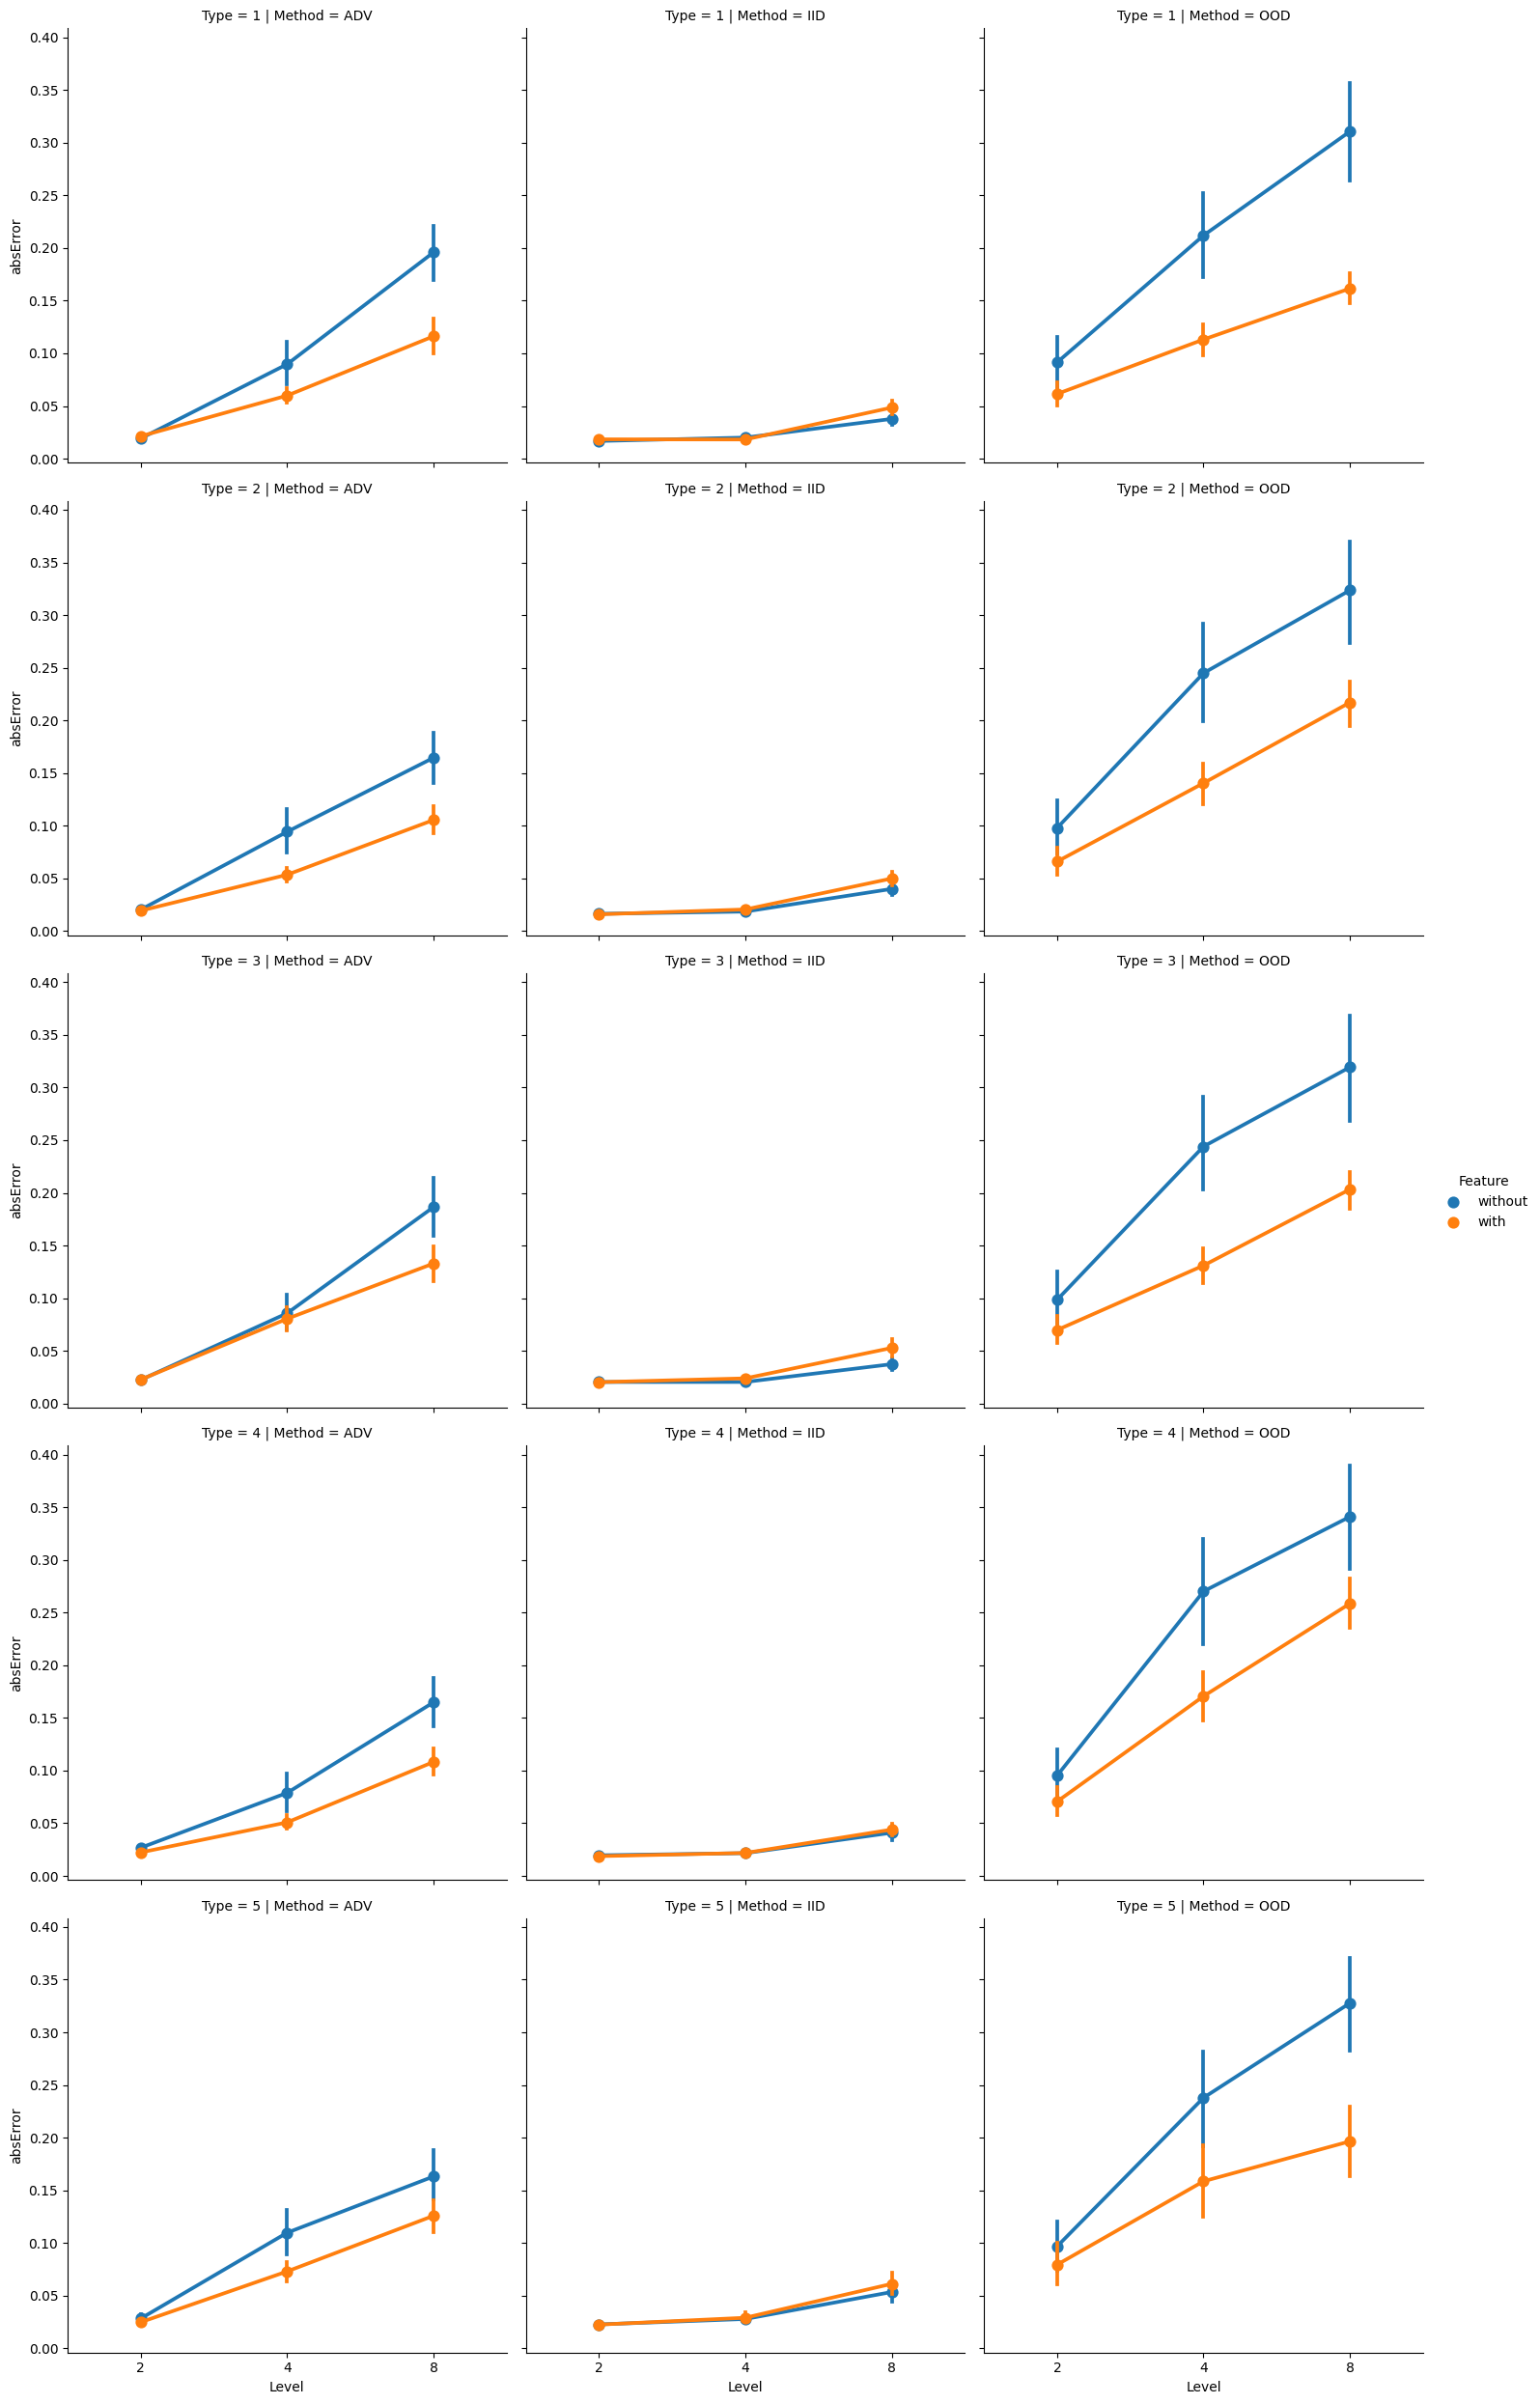

In [13]:
data = cnn_feature[
    (cnn_feature.Exp == "Ratio")
    & (cnn_feature.Model == "ResNet")
    & (cnn_feature.Level.isin([2, 4, 8]))
    & (cnn_feature.Method.isin(["IID", "ADV", "OOD"]))
    # & (cnn_feature.Type==1)
]
sns.catplot(
    data=data,
    x="Level",
    y="absError",
    col="Method",
    row="Type",
    hue="Feature",
    kind="point",
)

# More

In [4]:
cnn_Hm = pd.read_feather("results/formated_data/cnn_height_more.feather")
# combined = pd.concat([cnn] + humans, axis=0).reset_index(drop=True)
cnn_Hm["RawRatio"] = cnn_Hm.h / cnn_Hm.H
cnn_Hm["absError"] = np.abs(cnn_Hm.RawRatio - cnn_Hm.Pred)
cnn_Hm["Error"] = -(cnn_Hm.RawRatio - cnn_Hm.Pred)
cnn_Hm_agg = (
    cnn_Hm.groupby(["Model", "Run", "Type", "Method", "Level", "h", "H"])[
        ["Pred", "RawRatio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
    .groupby(["Model", "Run", "Type", "Method", "Level", "H"])[
        ["Pred", "RawRatio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
)

cnn_Rm = pd.read_feather("results/formated_data/cnn_ratio_more.feather")
cnn_Rm["RawRatio"] = cnn_Rm.h / cnn_Rm.H
cnn_Rm["absError"] = np.abs(cnn_Rm.RawRatio - cnn_Rm.Pred)
cnn_Rm["Error"] = -(cnn_Rm.RawRatio - cnn_Rm.Pred)
cnn_Rm["Ratio"] = cnn_Rm.RawRatio.apply(lambda x: round(x, 2))
cnn_Rm["SmallHeight"] = np.where(cnn_Rm.H < 20, "short", "tall")
cnn_Rm_agg = (
    cnn_Rm.groupby(["Model", "Run", "Type", "Method", "Level", "h", "H"])[
        ["Pred", "RawRatio", "Ratio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
)
cnn_Rm_agg["Ratio"] = round(cnn_Rm_agg.RawRatio, 2)
cnn_Rm_agg = (
    cnn_Rm_agg.groupby(["Model", "Run", "Type", "Method", "Level", "Ratio"])[
        ["Pred", "RawRatio", "absError", "Error"]
    ]
    .mean()
    .dropna()
    .reset_index()
)


cnn_Hm_agg["Exp"] = "Height"
cnn_Rm_agg["Exp"] = "Ratio"
cnnm = pd.concat([cnn_Hm_agg, cnn_Rm_agg], axis=0).reset_index(drop=True)
# cnn.loc[cnn.H < 20, "SmallHeight"] = "short"
# cnn.loc[cnn.H >= 20, "SmallHeight"] = "tall"

In [7]:
cnnm

,Model,Run,Type,Method,Level,H,Pred,RawRatio,absError,Error,Exp,Ratio
0,ResNet,0,1,ADV,2,6.0,0.485836,0.833333,0.347497,-0.347497,Height,NaN
1,ResNet,0,1,ADV,2,7.0,0.566247,0.785714,0.219468,-0.219468,Height,NaN
2,ResNet,0,1,ADV,2,14.0,0.623599,0.642857,0.043564,-0.019258,Height,NaN
3,ResNet,0,1,ADV,2,15.0,0.597060,0.633333,0.063634,-0.036274,Height,NaN
4,ResNet,0,1,ADV,2,17.0,0.560536,0.617647,0.067637,-0.057111,Height,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
144805,VGG,4,5,OOD_FIX,8,NaN,0.211697,0.940442,0.728745,-0.728745,Ratio,0.94
144806,VGG,4,5,OOD_FIX,8,NaN,0.178617,0.950663,0.772046,-0.772046,Ratio,0.95
144807,VGG,4,5,OOD_FIX,8,NaN,0.204099,0.959465,0.755366,-0.755366,Ratio,0.96
144808,VGG,4,5,OOD_FIX,8,NaN,0.177047,0.970330,0.793283,-0.793283,Ratio,0.97


In [8]:
cnn["Test"] = "Normal"
cnnm["Test"] = "More"
cnn_more = pd.concat([cnn, cnnm], axis=0).reset_index(drop=True)
cnn_more = cnn_more[(cnn_more.Method.isin(methods)) & (cnn_more.Level > 1)]

In [20]:
data = cnn_more[cnn_more.Exp == "Height"]

anova_results = anova_lm(
    ols("absError ~ Test * (Level + Method + C(Type) + Model)", data).fit()
)
tukeyhsd_results = to_tukey_table(pairwise_tukeyhsd(data["absError"], data["Test"]))
F, p, etasq, tukey_str = results_formatter(anova_results, tukeyhsd_results)
print(anova_results, "\n")
print(tukeyhsd_results, "\n")
print(f"{F}\t{p}\t{etasq}\t{tukey_str}\t")

                   df      sum_sq     mean_sq            F         PR(>F)  \
Test              1.0    0.869955    0.869955    56.697160   5.161131e-14   
Method            3.0  203.436516   67.812172  4419.489480   0.000000e+00   
C(Type)           4.0   13.375235    3.343809   217.924413  6.786621e-186   
Model             1.0    3.338366    3.338366   217.569683   3.807151e-49   
Test:Method       3.0    2.289119    0.763040    49.729220   4.358033e-32   
Test:C(Type)      4.0    0.055539    0.013885     0.904898   4.599363e-01   
Test:Model        1.0    0.003279    0.003279     0.213678   6.439016e-01   
Level             1.0  117.449033  117.449033  7654.448279   0.000000e+00   
Test:Level        1.0    0.439633    0.439633    28.651962   8.697237e-08   
Residual      54980.0  843.607217    0.015344          NaN            NaN   

                   Eta  
Test          0.000734  
Method        0.171696  
C(Type)       0.011288  
Model         0.002818  
Test:Method   0.001932  
Te

In [16]:
repr(tukeyhsd_results)

'  group1  group2  meandiff  p-adj   lower   upper  reject\n0   More  Normal   -0.0303    0.0 -0.0338 -0.0268    True'